In [1]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch_geometric.data import Data
import torch.optim as optim
import networkx as nx
from torch_geometric.utils.convert import to_networkx


In [2]:
# a graph with 4 nodes
edge_list = torch.tensor([
                         [0, 1, 1, 1, 2, 2, 3, 3], # Source Nodes
                         [1, 0, 2, 3, 1, 3, 1, 2]  # Target Nodes
                        ], dtype=torch.long)

# 6 Features for each node (4x6 - Number of nodes x NUmber of features)

node_features = torch.tensor([
                            [0,1], # Features of Node 0
                            [2,3], # Features of Node 1
                            [4,5], # Features of Node 2
                            [6,7], # Features of Node 3
                            ],dtype=torch.long)

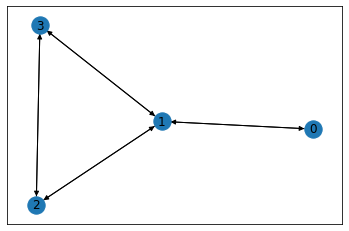

In [3]:
data = Data(x=node_features, edge_index=edge_list)
G = to_networkx(data)
nx.draw_networkx(G)

# Our first convolution

The convolution to be implemented, based on th GCN-Filter: Simplified Cheby-Filter involving 1-Hop Neighbors
![Convolution](convolution.png)

where g can be any arbitrary activation function (for simplicity we will skip the activation function)

In [4]:
node_features = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_features)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [5]:
## Source: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html
class SimpleConvolution(nn.Module): 

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out) ##  y=xAT+b

    def forward(self, node_features, adj_matrix):
        """
        Inputs:
            node_features - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        print("Number of neighbors per node:", num_neighbours)
        node_features = self.projection(node_features) ## HW
        node_features = torch.bmm(adj_matrix, node_features) # Matrix multiplication between A (Adjacent Matrix) and HW (note features)
        node_features = node_features / num_neighbours 
        return node_features

In [6]:
layer = SimpleConvolution(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]]) #Initialized the weigths to the identity matrix to let us validate the code. 
layer.projection.bias.data = torch.Tensor([0., 0.]) #bias term equal to zero

with torch.no_grad():
    out_features = layer(node_features, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_features)
print("Output features", out_features)


Number of neighbors per node: tensor([[[2.],
         [4.],
         [3.],
         [3.]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


## Final remarks

1. This can be seeing as the aggregation of 1-hop neighbors
2. We can stack this type of convolution to aggregate information from k-hop neighbors
3. We need to be careful because k increases the inputs of a node overlap with other nodes, smoothing too much the result